<h2>Important Packages</h2>

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

<h2>Load data and make train and test set</h2>

In [3]:
import os
from typing import List

def get_file_list(data_folder_path: str) -> List[str]:
    file_lst = []
    
    # Get all files in the directory
    for root, _, files in os.walk(data_folder_path):
        for file in files:
            if file.endswith('.csv',):  # Only consider CSV files
                file_path = os.path.join(root, file)
                # Append file path and its modification time
                file_lst.append(file_path)


    # Extract just the file paths
    return file_lst

In [4]:
data_folder = "data"
data_files = get_file_list('data')
df_list = [pd.read_csv(data_file) for data_file in data_files]

In [5]:
columns = df_list[1].columns

In [6]:
df_list[4]

,T1,T2,T3,T4,T5,T6,T7,T8,T9,T10,T11,T12,T13,T14,T15,Del
0,27.5,27.2,28.7,29.0,29.0,29.0,29.0,27.2,28.4,32.2,27.2,27.2,27.4,39.7,26.8,0
1,27.5,27.2,28.7,28.9,29.2,29.0,29.1,27.2,28.3,32.5,27.2,27.2,27.4,39.6,26.7,-3
2,27.3,27.2,28.7,28.8,29.0,29.0,29.1,27.2,28.3,32.4,27.1,27.2,27.6,39.6,26.8,-3
3,27.5,27.1,28.7,28.6,29.1,29.1,29.1,27.2,28.3,32.5,27.1,27.2,27.6,39.6,26.6,-3
4,27.5,27.1,28.5,28.7,29.1,28.9,29.1,27.2,28.3,32.5,27.1,27.2,27.6,39.6,26.8,-3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
345,29.9,32.8,37.1,37.9,38.9,38.9,38.9,32.4,37.3,62.5,31.1,32.9,31.4,55.5,30.6,42
346,29.9,32.7,37.3,38.0,38.9,38.9,38.9,32.4,37.2,62.5,31.1,32.9,31.4,55.6,30.4,42
347,30.1,33.0,37.3,38.0,38.9,38.9,38.9,32.3,37.1,62.3,31.1,32.9,31.4,55.5,30.4,43
348,29.8,32.9,37.3,38.0,38.9,38.9,38.9,32.3,37.1,62.4,31.1,32.8,31.4,55.2,30.4,42


<h4>Prepare data for LSTM model</h4>

In [6]:
from sklearn.model_selection import train_test_split

def save_past_dependence_merged_data(df_lst, window_size: int = 10):
    """
    Prepares and saves data for LSTM model with a sliding window approach.

    Parameters:
    - window_size: int, the number of past observations to consider for each sequence.
    """
    X_data, y_data = [], []

    save_path_train = 'temp/train_compressed.npz'
    save_path_test = 'temp/test_compressed.npz'

    for df in df_lst:
        df = df.dropna().reset_index(drop=True)  # Drop NaN values and reset index if needed
        m, n = df.shape
        
        # Generate sequences for the current dataframe
        for i in range(m - window_size):
            # Extract window of features (excluding the first column as features)
            X = df.iloc[i:i + window_size, :-1].values  # Use all columns except last one
            y = df.iloc[i + window_size, -1]  # Use the target column as last column

            X_data.append(X)
            y_data.append(y)

    # Convert lists to arrays
    X_data = np.array(X_data)
    y_data = np.array(y_data)

    trainX, testX, train_y, test_y = train_test_split(X_data, y_data, test_size=0.2, random_state=42)

    # Ensure directory exists and save the .npz file
    np.savez_compressed(save_path_train, X=trainX, y=train_y)
    np.savez_compressed(save_path_test, X=testX, y=test_y)
    print(f"Data saved to temp/...")

In [7]:
save_past_dependence_merged_data(df_list, window_size = 10)

Data saved to temp/...


In [7]:
training_data = np.load("temp/train_compressed.npz")
test_data = np.load("temp/test_compressed.npz")

trainX, train_y = training_data['X'], training_data['y']
testX, test_y = test_data['X'], test_data['y']

In [9]:
print(testX.shape)
print(trainX.shape)

(318, 10, 15)
(1272, 10, 15)


In [10]:
print(test_y.shape)
print(train_y.shape)

(318,)
(1272,)


In [11]:
testX

array([[[28.1, 29.4, 32.4, ..., 27.9, 48.1, 27.1],
        [28.1, 29.4, 32.4, ..., 27.9, 48.1, 27.1],
        [28.1, 29.4, 32.5, ..., 27.7, 47.9, 27.1],
        ...,
        [27.9, 29.4, 32.2, ..., 27.7, 47.3, 27.1],
        [27.9, 29.4, 32.2, ..., 27.7, 47.1, 27.2],
        [27.9, 29.4, 32.2, ..., 27.7, 47. , 27.1]],

       [[29. , 29.7, 34.4, ..., 29.3, 53.1, 29.4],
        [28.9, 29.7, 34.6, ..., 29.5, 53.3, 29.4],
        [28.9, 29.8, 34.7, ..., 29.5, 53.4, 29.4],
        ...,
        [28.7, 29.9, 34.9, ..., 29.5, 54. , 29.5],
        [28.8, 29.9, 34.9, ..., 29.5, 53.9, 29.4],
        [28.7, 29.9, 34.8, ..., 29.5, 54.1, 29.4]],

       [[30.1, 31.6, 36.2, ..., 30.7, 53.8, 29.9],
        [30.1, 31.6, 36.1, ..., 30.7, 54. , 29.9],
        [30. , 31.6, 36.2, ..., 30.6, 54. , 29.9],
        ...,
        [30.1, 31.7, 36.2, ..., 30.6, 54.1, 30.1],
        [30.1, 31.7, 36.4, ..., 30.8, 54. , 30.1],
        [30.1, 31.6, 36.4, ..., 30.7, 54. , 30.1]],

       ...,

       [[29.4, 31.1, 36.

In [12]:
test_y

array([24, 26, 40,  0,  7, 25, 28, 11,  8,  7, 19, 12, 24, 41, 39, 30, 10,
        8, 49, 27, 20, 48, 41, 33,  9, 43, 17, 43,  6, 18, 28, 20, 32, 12,
       19, 24, 46,  1, 18, 27,  1,  8, 13, 11, 25, 13, 47, 27,  3, 16, 25,
       43, 11, 27,  0, 39, 17, 31, 21, 15, 20, 17,  8,  1, 50, 22, 38, 12,
       18, 24, 18, 13, 14, 19, 40, 35, 12, 26, 23, 33, 42, 21, 25, 21, 24,
       34, 41, 28, 31, 37, 35, 20, 15, 48, 40, 19, 43, 19, 41, 11,  9, 39,
        4, 27, 23, 18, 28, 47, 15, 23,  7, 29, 27, 34, 24, 35, 19, 17, 27,
        7, 14, 21, 16,  1, 22, 29,  9, 11,  4, 41, 18, 33, 17, 26, 12, 10,
       42, 23, 33, 19,  9, 33, 24,  2, 19, 36, 38, 26, 36, 42, 52, 13, 14,
       46, 23, 21, 28, 26, 10, 27, 21, 21, 16, 35, 41, 21, 43, 26, 26, 16,
       17, 50, 32, 51, 42, 36, 41, 42,  3, 13,  6,  6, 49, 25, 30, 33, 24,
       18, 30, 28, 15, 28, 36, 10, 27, 29, 29, 23, 11, 34, 22,  4, 21,  9,
       39,  7, 11, 32, 41, 13, 28, 22, 18,  3, 23,  5, 39, 11, 38, 42, 21,
       26, 27, 17, 30, 13

<h2>Build Objective function</h2>

In [8]:
import optuna
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from sklearn.metrics import mean_squared_error
from tensorflow.keras.callbacks import EarlyStopping

/home/imran/github space/OptimizationAlgo/ConferenceEnv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-01-27 15:46:58.282554: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-27 15:47:01.802129: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-27 15:47:03.958403: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1737973026.004681    7769 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1737973026.470713

<h4>Test a LSTM model with manual hyperparameter</h4>

In [14]:
m,n,h = trainX.shape

model = Sequential()
model.add(Input(shape=(n,h)))
model.add(LSTM(units=70))
model.add(Dropout(rate=0.1))

model.add(Dense(units=1, activation="linear"))  # Output layer

    # Compile the model
optimizer = Adam(learning_rate=0.01)
model.compile(optimizer=optimizer, loss="mse")

# Early stopping
early_stopping = EarlyStopping(monitor="val_loss", patience=20, restore_best_weights=True)

# Train the model
history = model.fit(
    trainX, train_y,
    validation_split=0.2,  # Correct argument
    epochs=100,
    batch_size=16,
    callbacks=[early_stopping],
    verbose=1
    )

    # Evaluate the model
y_pred = model.predict(testX)
mse = mean_squared_error(test_y, y_pred.reshape(-1))

2025-01-27 11:18:24.580747: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Epoch 1/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - loss: 380.0468 - val_loss: 151.6370
Epoch 2/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 150.7446 - val_loss: 144.1126
Epoch 3/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 154.6444 - val_loss: 143.6234
Epoch 4/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 141.7528 - val_loss: 144.7541
Epoch 5/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 157.9633 - val_loss: 146.8393
Epoch 6/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 163.5557 - val_loss: 143.1879
Epoch 7/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 153.3911 - val_loss: 142.9816
Epoch 8/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 148.5334 - val_loss: 143.9023
Epoch 9/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 148.3754 - val_loss: 143.3748
Epoch 10/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 150.6461 - val_loss: 143.1109
Epoch 11/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 148.5883 - val_loss: 146.2011
Epoch 12

In [18]:
np.argmin(history.history['loss'])

np.int64(36)

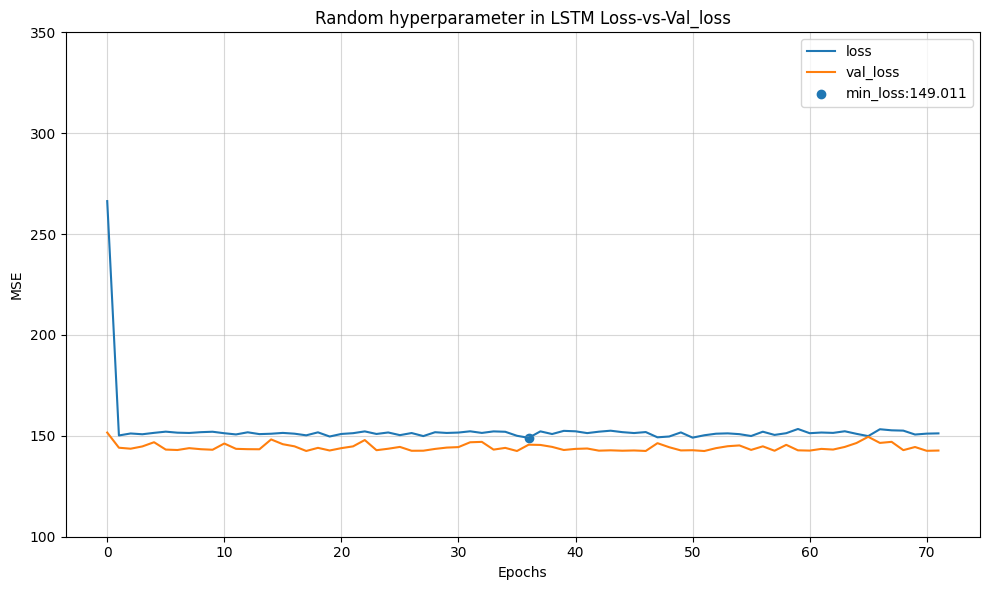

In [26]:
plt.figure(figsize=(10,6))

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.scatter(np.argmin(history.history['loss']), min(history.history['loss']))

plt.grid(True, alpha=0.5)
plt.legend(['loss', 'val_loss', f"min_loss:{ round(min(history.history['loss']), ndigits=3) }"])
plt.title("Random hyperparameter in LSTM Loss-vs-Val_loss")

plt.yticks(np.arange(100,400, 50))
plt.xlabel('Epochs')
plt.ylabel("MSE")

plt.tight_layout()
plt.savefig("img/random_loss_val_loss.png")

plt.show()

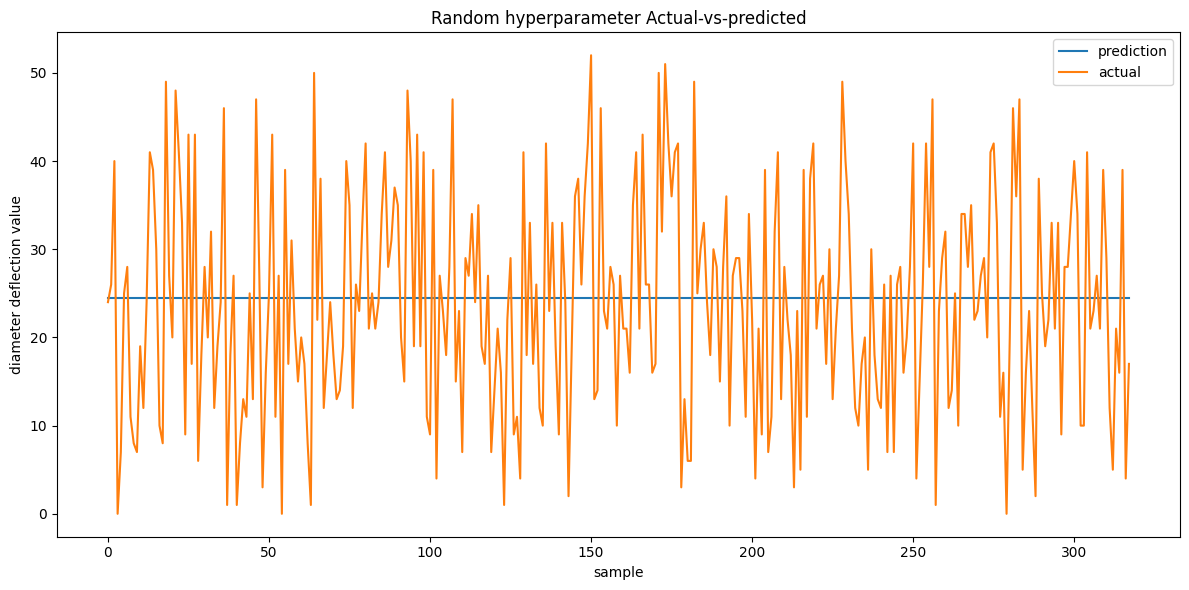

In [28]:
plt.figure(figsize=(12, 6))

# Plotting loss
plt.plot(y_pred, label='prediction')
plt.plot(test_y, label='actual')

# plt.xticks(np.arange(0, 100, 10))
# plt.yticks(np.arange(0, 600, 50))
# # Adding grid
# plt.grid(True, alpha=0.6, which='major', )  # Set grid opacity

# plt.xlabel('Epoch', fontsize=12)
# plt.ylabel('MSE', fontsize=12)

plt.legend()
plt.xlabel("sample")
plt.ylabel('diameter deflection value')

#plt.legend(['loss','val_loss'])
plt.title("Random hyperparameter Actual-vs-predicted")

plt.tight_layout()
plt.savefig('img/random_actual_predicted.png')
plt.show()

In [74]:
# Objective function
m,n,h = trainX.shape
def objective(trial):
    # Hyperparameter tuning
    num_units = trial.suggest_int("num_units", 16, 224, step=16)
    num_layers = trial.suggest_int("num_layers", 1, 3)
    dropout_rate = trial.suggest_float("dropout_rate", 0.1, 0.5)
    learning_rate = trial.suggest_float("learning_rate", 1e-4, 1e-2, log=True)
    batch_size = trial.suggest_int("batch_size", 16, 128, step=16)
    epochs = trial.suggest_int("epochs", 10, 100, step=10)
    

    # Model definition
    model = Sequential()

    if num_layers > 1:
        model.add(LSTM(units=num_units, return_sequences=True, input_shape=(n,h)))
        model.add(Dropout(rate=dropout_rate))
    else:
        model.add(LSTM(units=num_units, return_sequences=False, input_shape=(n,h)))
    
    model.add(Dropout(rate=dropout_rate))
    
    for _ in range(num_layers-2):
        model.add(LSTM(units=num_units, return_sequences=True))
        model.add(Dropout(rate=dropout_rate))

    if(num_layers > 1):
        model.add(LSTM(units=num_units, return_sequences=False))
        model.add(Dropout(rate=dropout_rate))
    model.add(Dense(units=1, activation='linear'))  # Output layer

    # Compile the model
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss="mse")

    
    early_stopping = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
    
    model.fit(
        trainX, train_y,
        validation_split = 0.2,
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[early_stopping],
        verbose=0
    )
    
    # Evaluate the model
    y_pred = model.predict(testX)
    mse = mean_squared_error(test_y, y_pred)
    
    return mse

In [75]:
study = optuna.create_study(direction="minimize", study_name="Tree Parzen Optimization of LSTM")
study.optimize(objective, n_trials=50)

[I 2025-01-13 11:22:49,689] A new study created in memory with name: Tree Parzen Optimization of LSTM
/home/imran/github space/OptimizationAlgo/ConferenceEnv/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step


[I 2025-01-13 11:23:13,710] Trial 0 finished with value: 152.34910583496094 and parameters: {'num_units': 192, 'num_layers': 2, 'dropout_rate': 0.19418846214335295, 'learning_rate': 0.008262160737995673, 'batch_size': 80, 'epochs': 100}. Best is trial 0 with value: 152.34910583496094.
/home/imran/github space/OptimizationAlgo/ConferenceEnv/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step


[I 2025-01-13 11:23:31,711] Trial 1 finished with value: 152.30018615722656 and parameters: {'num_units': 48, 'num_layers': 3, 'dropout_rate': 0.1509907724983689, 'learning_rate': 0.003943473368871887, 'batch_size': 48, 'epochs': 60}. Best is trial 1 with value: 152.30018615722656.
/home/imran/github space/OptimizationAlgo/ConferenceEnv/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step


[I 2025-01-13 11:24:13,665] Trial 2 finished with value: 16.597192764282227 and parameters: {'num_units': 160, 'num_layers': 1, 'dropout_rate': 0.42151492114692546, 'learning_rate': 0.0003571083376668573, 'batch_size': 32, 'epochs': 80}. Best is trial 2 with value: 16.597192764282227.
/home/imran/github space/OptimizationAlgo/ConferenceEnv/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 191ms/step


[I 2025-01-13 11:25:22,773] Trial 3 finished with value: 208.03282165527344 and parameters: {'num_units': 128, 'num_layers': 3, 'dropout_rate': 0.24841063108883166, 'learning_rate': 0.00010340354654668803, 'batch_size': 128, 'epochs': 30}. Best is trial 2 with value: 16.597192764282227.
/home/imran/github space/OptimizationAlgo/ConferenceEnv/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step


[I 2025-01-13 11:26:03,106] Trial 4 finished with value: 502.5484924316406 and parameters: {'num_units': 16, 'num_layers': 1, 'dropout_rate': 0.2545977599687691, 'learning_rate': 0.00011063378455531259, 'batch_size': 32, 'epochs': 100}. Best is trial 2 with value: 16.597192764282227.
/home/imran/github space/OptimizationAlgo/ConferenceEnv/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 121ms/step


[I 2025-01-13 11:31:06,010] Trial 5 finished with value: 8.794139862060547 and parameters: {'num_units': 208, 'num_layers': 2, 'dropout_rate': 0.14177013906170421, 'learning_rate': 0.0003910387801777331, 'batch_size': 128, 'epochs': 100}. Best is trial 5 with value: 8.794139862060547.
/home/imran/github space/OptimizationAlgo/ConferenceEnv/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 153ms/step


[I 2025-01-13 11:33:40,951] Trial 6 finished with value: 156.4988555908203 and parameters: {'num_units': 160, 'num_layers': 3, 'dropout_rate': 0.4430273413431065, 'learning_rate': 0.00011676933625757358, 'batch_size': 96, 'epochs': 40}. Best is trial 5 with value: 8.794139862060547.
/home/imran/github space/OptimizationAlgo/ConferenceEnv/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step


[I 2025-01-13 11:34:12,064] Trial 7 finished with value: 106.46019744873047 and parameters: {'num_units': 144, 'num_layers': 1, 'dropout_rate': 0.17039041041152692, 'learning_rate': 0.0014949454361561957, 'batch_size': 32, 'epochs': 20}. Best is trial 5 with value: 8.794139862060547.
/home/imran/github space/OptimizationAlgo/ConferenceEnv/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 116ms/step


[I 2025-01-13 11:34:30,177] Trial 8 finished with value: 171.7790069580078 and parameters: {'num_units': 32, 'num_layers': 3, 'dropout_rate': 0.25598694756154156, 'learning_rate': 0.0049401853186803015, 'batch_size': 112, 'epochs': 10}. Best is trial 5 with value: 8.794139862060547.
/home/imran/github space/OptimizationAlgo/ConferenceEnv/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step


[I 2025-01-13 11:34:45,063] Trial 9 finished with value: 152.64146423339844 and parameters: {'num_units': 176, 'num_layers': 1, 'dropout_rate': 0.33658321230044486, 'learning_rate': 0.006225872546230961, 'batch_size': 112, 'epochs': 30}. Best is trial 5 with value: 8.794139862060547.
/home/imran/github space/OptimizationAlgo/ConferenceEnv/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 181ms/step


[I 2025-01-13 11:38:54,902] Trial 10 finished with value: 12.617300033569336 and parameters: {'num_units': 224, 'num_layers': 2, 'dropout_rate': 0.11872993879098248, 'learning_rate': 0.0004838675365850778, 'batch_size': 64, 'epochs': 70}. Best is trial 5 with value: 8.794139862060547.
/home/imran/github space/OptimizationAlgo/ConferenceEnv/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 174ms/step


[I 2025-01-13 11:42:53,429] Trial 11 finished with value: 12.790966033935547 and parameters: {'num_units': 224, 'num_layers': 2, 'dropout_rate': 0.10189869225672776, 'learning_rate': 0.0005414281704708538, 'batch_size': 64, 'epochs': 70}. Best is trial 5 with value: 8.794139862060547.
/home/imran/github space/OptimizationAlgo/ConferenceEnv/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 174ms/step


[I 2025-01-13 11:46:57,614] Trial 12 finished with value: 9.772314071655273 and parameters: {'num_units': 224, 'num_layers': 2, 'dropout_rate': 0.10134004732981447, 'learning_rate': 0.0003802965790884047, 'batch_size': 64, 'epochs': 80}. Best is trial 5 with value: 8.794139862060547.
/home/imran/github space/OptimizationAlgo/ConferenceEnv/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 101ms/step


[I 2025-01-13 11:48:36,315] Trial 13 finished with value: 100.08141326904297 and parameters: {'num_units': 80, 'num_layers': 2, 'dropout_rate': 0.3443170053524472, 'learning_rate': 0.0002468507799278272, 'batch_size': 80, 'epochs': 90}. Best is trial 5 with value: 8.794139862060547.
/home/imran/github space/OptimizationAlgo/ConferenceEnv/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step


[I 2025-01-13 11:49:14,873] Trial 14 finished with value: 152.2548828125 and parameters: {'num_units': 208, 'num_layers': 2, 'dropout_rate': 0.21196467366764324, 'learning_rate': 0.001176005086616002, 'batch_size': 128, 'epochs': 80}. Best is trial 5 with value: 8.794139862060547.
/home/imran/github space/OptimizationAlgo/ConferenceEnv/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 102ms/step


[I 2025-01-13 11:52:15,629] Trial 15 finished with value: 8.538989067077637 and parameters: {'num_units': 96, 'num_layers': 2, 'dropout_rate': 0.14310311885241903, 'learning_rate': 0.0002352362187582648, 'batch_size': 16, 'epochs': 90}. Best is trial 15 with value: 8.538989067077637.
/home/imran/github space/OptimizationAlgo/ConferenceEnv/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 112ms/step


[I 2025-01-13 11:54:42,878] Trial 16 finished with value: 13.634037971496582 and parameters: {'num_units': 96, 'num_layers': 2, 'dropout_rate': 0.48885490416059973, 'learning_rate': 0.0002213333556335092, 'batch_size': 16, 'epochs': 100}. Best is trial 15 with value: 8.538989067077637.
/home/imran/github space/OptimizationAlgo/ConferenceEnv/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step


[I 2025-01-13 11:55:46,227] Trial 17 finished with value: 14.102981567382812 and parameters: {'num_units': 96, 'num_layers': 1, 'dropout_rate': 0.31946618763783063, 'learning_rate': 0.0009268735351403292, 'batch_size': 16, 'epochs': 50}. Best is trial 15 with value: 8.538989067077637.
/home/imran/github space/OptimizationAlgo/ConferenceEnv/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 104ms/step


[I 2025-01-13 11:57:33,843] Trial 18 finished with value: 164.14186096191406 and parameters: {'num_units': 64, 'num_layers': 3, 'dropout_rate': 0.16307109472444128, 'learning_rate': 0.0002155311050716088, 'batch_size': 96, 'epochs': 90}. Best is trial 15 with value: 8.538989067077637.
/home/imran/github space/OptimizationAlgo/ConferenceEnv/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step


[I 2025-01-13 11:57:52,658] Trial 19 finished with value: 152.29075622558594 and parameters: {'num_units': 112, 'num_layers': 2, 'dropout_rate': 0.21877527340015235, 'learning_rate': 0.0024399818615124164, 'batch_size': 48, 'epochs': 90}. Best is trial 15 with value: 8.538989067077637.
/home/imran/github space/OptimizationAlgo/ConferenceEnv/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step


[I 2025-01-13 11:59:21,999] Trial 20 finished with value: 64.9163589477539 and parameters: {'num_units': 112, 'num_layers': 2, 'dropout_rate': 0.2887405092834888, 'learning_rate': 0.0007160998410898674, 'batch_size': 96, 'epochs': 60}. Best is trial 15 with value: 8.538989067077637.
/home/imran/github space/OptimizationAlgo/ConferenceEnv/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 185ms/step


[I 2025-01-13 12:03:55,960] Trial 21 finished with value: 8.94539737701416 and parameters: {'num_units': 192, 'num_layers': 2, 'dropout_rate': 0.13225751964185178, 'learning_rate': 0.00040360108552221405, 'batch_size': 48, 'epochs': 80}. Best is trial 15 with value: 8.538989067077637.
/home/imran/github space/OptimizationAlgo/ConferenceEnv/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 262ms/step


[I 2025-01-13 12:07:19,386] Trial 22 finished with value: 22.28600311279297 and parameters: {'num_units': 192, 'num_layers': 2, 'dropout_rate': 0.1306926627696053, 'learning_rate': 0.00017730648920080266, 'batch_size': 48, 'epochs': 90}. Best is trial 15 with value: 8.538989067077637.
/home/imran/github space/OptimizationAlgo/ConferenceEnv/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 144ms/step


[I 2025-01-13 12:10:33,670] Trial 23 finished with value: 10.18084716796875 and parameters: {'num_units': 144, 'num_layers': 2, 'dropout_rate': 0.1821275454256295, 'learning_rate': 0.0003391043883327584, 'batch_size': 16, 'epochs': 70}. Best is trial 15 with value: 8.538989067077637.
/home/imran/github space/OptimizationAlgo/ConferenceEnv/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 163ms/step


[I 2025-01-13 12:14:06,659] Trial 24 finished with value: 11.815962791442871 and parameters: {'num_units': 192, 'num_layers': 2, 'dropout_rate': 0.14443501415115562, 'learning_rate': 0.0006746287805115762, 'batch_size': 32, 'epochs': 100}. Best is trial 15 with value: 8.538989067077637.
/home/imran/github space/OptimizationAlgo/ConferenceEnv/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step


[I 2025-01-13 12:15:55,967] Trial 25 finished with value: 15.895482063293457 and parameters: {'num_units': 176, 'num_layers': 1, 'dropout_rate': 0.21836496899999353, 'learning_rate': 0.00017688659568308433, 'batch_size': 48, 'epochs': 80}. Best is trial 15 with value: 8.538989067077637.
/home/imran/github space/OptimizationAlgo/ConferenceEnv/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 204ms/step


[I 2025-01-13 12:20:35,591] Trial 26 finished with value: 16.973962783813477 and parameters: {'num_units': 128, 'num_layers': 3, 'dropout_rate': 0.13733313372630976, 'learning_rate': 0.00032794970739457696, 'batch_size': 80, 'epochs': 90}. Best is trial 15 with value: 8.538989067077637.
/home/imran/github space/OptimizationAlgo/ConferenceEnv/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 167ms/step


[I 2025-01-13 12:21:55,278] Trial 27 finished with value: 152.68771362304688 and parameters: {'num_units': 208, 'num_layers': 2, 'dropout_rate': 0.37465774958881987, 'learning_rate': 0.0019101587350707466, 'batch_size': 16, 'epochs': 100}. Best is trial 15 with value: 8.538989067077637.
/home/imran/github space/OptimizationAlgo/ConferenceEnv/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 97ms/step


[I 2025-01-13 12:22:57,771] Trial 28 finished with value: 128.4215087890625 and parameters: {'num_units': 80, 'num_layers': 2, 'dropout_rate': 0.183983530101852, 'learning_rate': 0.0004915176743227987, 'batch_size': 112, 'epochs': 70}. Best is trial 15 with value: 8.538989067077637.
/home/imran/github space/OptimizationAlgo/ConferenceEnv/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step


[I 2025-01-13 12:24:06,800] Trial 29 finished with value: 28.893203735351562 and parameters: {'num_units': 192, 'num_layers': 1, 'dropout_rate': 0.20424087637040433, 'learning_rate': 0.0008712252046106958, 'batch_size': 32, 'epochs': 100}. Best is trial 15 with value: 8.538989067077637.
/home/imran/github space/OptimizationAlgo/ConferenceEnv/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 149ms/step


[I 2025-01-13 12:26:43,174] Trial 30 finished with value: 102.7384262084961 and parameters: {'num_units': 160, 'num_layers': 3, 'dropout_rate': 0.2869207369185392, 'learning_rate': 0.00015657647897076156, 'batch_size': 80, 'epochs': 50}. Best is trial 15 with value: 8.538989067077637.
/home/imran/github space/OptimizationAlgo/ConferenceEnv/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 176ms/step


[I 2025-01-13 12:31:10,321] Trial 31 finished with value: 8.990277290344238 and parameters: {'num_units': 224, 'num_layers': 2, 'dropout_rate': 0.10098534469074928, 'learning_rate': 0.0002814326190834275, 'batch_size': 64, 'epochs': 80}. Best is trial 15 with value: 8.538989067077637.
/home/imran/github space/OptimizationAlgo/ConferenceEnv/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 165ms/step


[I 2025-01-13 12:34:48,068] Trial 32 finished with value: 10.39826488494873 and parameters: {'num_units': 208, 'num_layers': 2, 'dropout_rate': 0.12178072714378659, 'learning_rate': 0.00027311321822728765, 'batch_size': 64, 'epochs': 80}. Best is trial 15 with value: 8.538989067077637.
/home/imran/github space/OptimizationAlgo/ConferenceEnv/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 170ms/step


[I 2025-01-13 12:37:29,072] Trial 33 finished with value: 18.16253089904785 and parameters: {'num_units': 208, 'num_layers': 2, 'dropout_rate': 0.14789483273795628, 'learning_rate': 0.00042960014009073424, 'batch_size': 48, 'epochs': 60}. Best is trial 15 with value: 8.538989067077637.
/home/imran/github space/OptimizationAlgo/ConferenceEnv/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 156ms/step


[I 2025-01-13 12:40:28,966] Trial 34 finished with value: 14.039552688598633 and parameters: {'num_units': 176, 'num_layers': 2, 'dropout_rate': 0.1619715458381702, 'learning_rate': 0.00028671683013490093, 'batch_size': 48, 'epochs': 90}. Best is trial 15 with value: 8.538989067077637.
/home/imran/github space/OptimizationAlgo/ConferenceEnv/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 176ms/step


[I 2025-01-13 12:46:30,411] Trial 35 finished with value: 9.453450202941895 and parameters: {'num_units': 224, 'num_layers': 2, 'dropout_rate': 0.1059612376622655, 'learning_rate': 0.0001511674858151422, 'batch_size': 64, 'epochs': 80}. Best is trial 15 with value: 8.538989067077637.
/home/imran/github space/OptimizationAlgo/ConferenceEnv/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step


[I 2025-01-13 12:47:28,389] Trial 36 finished with value: 94.92032623291016 and parameters: {'num_units': 48, 'num_layers': 2, 'dropout_rate': 0.19205536041807342, 'learning_rate': 0.0006078544032113508, 'batch_size': 80, 'epochs': 100}. Best is trial 15 with value: 8.538989067077637.
/home/imran/github space/OptimizationAlgo/ConferenceEnv/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 143ms/step


[I 2025-01-13 12:48:08,552] Trial 37 finished with value: 153.07989501953125 and parameters: {'num_units': 144, 'num_layers': 2, 'dropout_rate': 0.1305749769437247, 'learning_rate': 0.009168903396833511, 'batch_size': 32, 'epochs': 90}. Best is trial 15 with value: 8.538989067077637.
/home/imran/github space/OptimizationAlgo/ConferenceEnv/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 237ms/step


[I 2025-01-13 12:53:23,231] Trial 38 finished with value: 11.625 and parameters: {'num_units': 192, 'num_layers': 3, 'dropout_rate': 0.24914798829450535, 'learning_rate': 0.0003985221889391516, 'batch_size': 96, 'epochs': 70}. Best is trial 15 with value: 8.538989067077637.
/home/imran/github space/OptimizationAlgo/ConferenceEnv/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 102ms/step


[I 2025-01-13 12:55:16,575] Trial 39 finished with value: 11.78696346282959 and parameters: {'num_units': 160, 'num_layers': 1, 'dropout_rate': 0.17349601968773085, 'learning_rate': 0.00012961242541609808, 'batch_size': 32, 'epochs': 80}. Best is trial 15 with value: 8.538989067077637.
/home/imran/github space/OptimizationAlgo/ConferenceEnv/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 238ms/step


[I 2025-01-13 13:04:18,199] Trial 40 finished with value: 14.690492630004883 and parameters: {'num_units': 208, 'num_layers': 3, 'dropout_rate': 0.15559247899619788, 'learning_rate': 0.00019444705041364848, 'batch_size': 128, 'epochs': 100}. Best is trial 15 with value: 8.538989067077637.
/home/imran/github space/OptimizationAlgo/ConferenceEnv/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step


[I 2025-01-13 13:10:18,286] Trial 41 finished with value: 9.079008102416992 and parameters: {'num_units': 224, 'num_layers': 2, 'dropout_rate': 0.10172288442859845, 'learning_rate': 0.00014801222480215727, 'batch_size': 64, 'epochs': 80}. Best is trial 15 with value: 8.538989067077637.
/home/imran/github space/OptimizationAlgo/ConferenceEnv/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 168ms/step


[I 2025-01-13 13:15:37,496] Trial 42 finished with value: 15.639434814453125 and parameters: {'num_units': 224, 'num_layers': 2, 'dropout_rate': 0.1190175371015954, 'learning_rate': 0.00010663917525878659, 'batch_size': 64, 'epochs': 80}. Best is trial 15 with value: 8.538989067077637.
/home/imran/github space/OptimizationAlgo/ConferenceEnv/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 133ms/step


[I 2025-01-13 13:20:51,737] Trial 43 finished with value: 13.734869003295898 and parameters: {'num_units': 224, 'num_layers': 2, 'dropout_rate': 0.10493709895927081, 'learning_rate': 0.00014202253148302665, 'batch_size': 64, 'epochs': 70}. Best is trial 15 with value: 8.538989067077637.
/home/imran/github space/OptimizationAlgo/ConferenceEnv/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 260ms/step


[I 2025-01-13 13:23:58,332] Trial 44 finished with value: 10.427190780639648 and parameters: {'num_units': 208, 'num_layers': 2, 'dropout_rate': 0.14378729015399005, 'learning_rate': 0.00028860000853063125, 'batch_size': 48, 'epochs': 90}. Best is trial 15 with value: 8.538989067077637.
/home/imran/github space/OptimizationAlgo/ConferenceEnv/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 196ms/step


[I 2025-01-13 13:28:49,659] Trial 45 finished with value: 16.439559936523438 and parameters: {'num_units': 176, 'num_layers': 2, 'dropout_rate': 0.23192950553410052, 'learning_rate': 0.0002310238682709574, 'batch_size': 80, 'epochs': 90}. Best is trial 15 with value: 8.538989067077637.
/home/imran/github space/OptimizationAlgo/ConferenceEnv/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 157ms/step


[I 2025-01-13 13:33:39,351] Trial 46 finished with value: 20.40985870361328 and parameters: {'num_units': 224, 'num_layers': 2, 'dropout_rate': 0.11513822031104567, 'learning_rate': 0.0003412410025189239, 'batch_size': 112, 'epochs': 60}. Best is trial 15 with value: 8.538989067077637.
/home/imran/github space/OptimizationAlgo/ConferenceEnv/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 230ms/step


[I 2025-01-13 13:36:50,412] Trial 47 finished with value: 17.375186920166016 and parameters: {'num_units': 192, 'num_layers': 2, 'dropout_rate': 0.13042879281692688, 'learning_rate': 0.0004731185710096884, 'batch_size': 64, 'epochs': 40}. Best is trial 15 with value: 8.538989067077637.
/home/imran/github space/OptimizationAlgo/ConferenceEnv/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 109ms/step


[I 2025-01-13 13:39:35,943] Trial 48 finished with value: 167.71945190429688 and parameters: {'num_units': 96, 'num_layers': 2, 'dropout_rate': 0.16037399293160362, 'learning_rate': 0.0001005012936602318, 'batch_size': 80, 'epochs': 80}. Best is trial 15 with value: 8.538989067077637.
/home/imran/github space/OptimizationAlgo/ConferenceEnv/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step


[I 2025-01-13 13:42:19,009] Trial 49 finished with value: 19.84587287902832 and parameters: {'num_units': 128, 'num_layers': 2, 'dropout_rate': 0.10049839813058088, 'learning_rate': 0.00019295557853659032, 'batch_size': 48, 'epochs': 70}. Best is trial 15 with value: 8.538989067077637.


In [77]:
study.best_params

{'num_units': 96,
 'num_layers': 2,
 'dropout_rate': 0.14310311885241903,
 'learning_rate': 0.0002352362187582648,
 'batch_size': 16,
 'epochs': 90}

<h1>Model build using BEst hyper parameter</h1>

In [31]:
m,n,h = trainX.shape

opt_model = Sequential()
opt_model.add(Input(shape=(n,h)))
opt_model.add(LSTM(units=96, return_sequences=True))
opt_model.add(Dropout(rate=0.14310311885241903))

opt_model.add(LSTM(units=96))
opt_model.add(Dropout(rate=0.14310311885241903))


opt_model.add(Dense(units=1, activation="linear"))  # Output layer

    # Compile the model
opt_optimizer = Adam(learning_rate=0.0002352362187582648)
opt_model.compile(optimizer=opt_optimizer, loss="mse")

# Early stopping
opt_early_stopping = EarlyStopping(monitor="val_loss", patience=8, restore_best_weights=True)

# Train the model
opt_history = opt_model.fit(
    trainX, train_y,
    validation_split=0.2,  # Correct argument
    epochs=90,
    batch_size=16,
    callbacks=[opt_early_stopping],
    verbose=1
    )

    # Evaluate the model
opt_y_pred = opt_model.predict(testX)
opt_mse = mean_squared_error(test_y, opt_y_pred.reshape(-1))

Epoch 1/90
64/64 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - loss: 601.2975 - val_loss: 348.3430
Epoch 2/90
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 290.9700 - val_loss: 240.3818
Epoch 3/90
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 208.9600 - val_loss: 212.3718
Epoch 4/90
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 198.8122 - val_loss: 193.2040
Epoch 5/90
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 183.9506 - val_loss: 179.9327
Epoch 6/90
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 174.8858 - val_loss: 169.7798
Epoch 7/90
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 157.6478 - val_loss: 162.1527
Epoch 8/90
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 157.5061 - val_loss: 156.8571
Epoch 9/90
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 150.7219 - val_loss: 153.2617
Epoch 10/90
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 141.5935 - val_loss: 150.4160
Epoch 11/90
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 151.5578 - val_loss: 148.3503
Epoch 12/90
64/64 ━

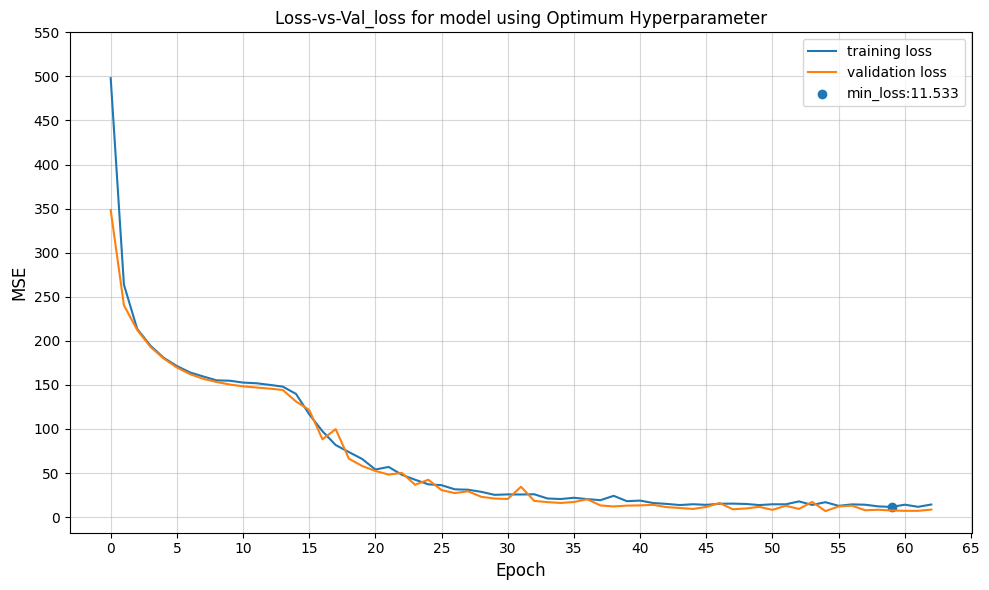

In [33]:
plt.figure(figsize=(10, 6))

# Plotting loss
plt.plot(opt_history.history['loss'])
plt.plot(opt_history.history['val_loss'])

plt.scatter(np.argmin(opt_history.history['loss']), min(opt_history.history['loss']))

plt.grid(True, alpha=0.5)
plt.legend(['training loss', 'validation loss', f"min_loss:{ round(min(opt_history.history['loss']), ndigits=3) }"])

plt.xticks(np.arange(0, 70, 5))
plt.yticks(np.arange(0, 600, 50))


plt.xlabel('Epoch', fontsize=12)
plt.ylabel('MSE', fontsize=12)


#plt.legend(['loss','val_loss'])
plt.title("Loss-vs-Val_loss for model using Optimum Hyperparameter")

plt.tight_layout()
plt.savefig('img/optuna_param_loss_plot.png')
plt.show()

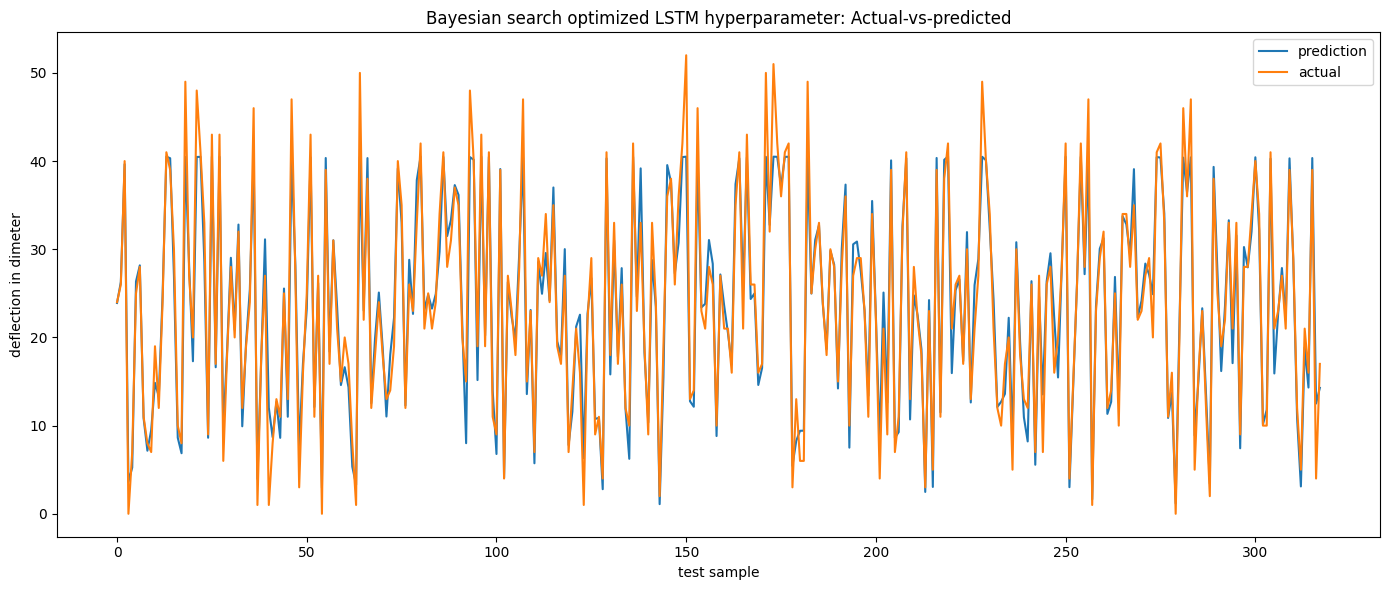

In [43]:
plt.figure(figsize=(14, 6))

# Plotting loss
plt.plot(opt_y_pred, label='prediction')
plt.plot(test_y, label='actual')

# plt.xticks(np.arange(0, 100, 10))
# plt.yticks(np.arange(0, 600, 50))
# # Adding grid
# plt.grid(True, alpha=0.6, which='major', )  # Set grid opacity

plt.ylabel('deflection in dimeter')
plt.xlabel('test sample')

plt.legend()

#plt.legend(['loss','val_loss'])
plt.title("Bayesian search optimized LSTM hyperparameter: Actual-vs-predicted")

plt.tight_layout()
plt.savefig('img/bayes_based_actual_predicted.png')
plt.show()

In [16]:
from optimizers import GWO_l
m,n,h = trainX.shape
def objective_for_gwo(params):
    num_units = int(params[0])
    num_layers = int(params[1])
    dropout_rate = params[2]
    learning_rate = params[3]
    batch_size = int(params[4])
    epochs = int(params[5])
    
    # Model definition
    model = Sequential()
    model.add(Input(shape=(n, h)))

    if num_layers > 1:
        model.add(LSTM(units=num_units, return_sequences=True))
        model.add(Dropout(rate=dropout_rate))
    else:
        model.add(LSTM(units=num_units, return_sequences=False))
    model.add(Dropout(rate=dropout_rate))

    for _ in range(num_layers - 2):
        model.add(LSTM(units=num_units, return_sequences=True))
        model.add(Dropout(rate=dropout_rate))

    if num_layers > 1:
        model.add(LSTM(units=num_units, return_sequences=False))
        model.add(Dropout(rate=dropout_rate))

    model.add(Dense(units=1, activation="linear"))

    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss="mse")

    # Train the model
    early_stopping = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
    model.fit(
        trainX, train_y,
        validation_split=0.2,
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[early_stopping],
        verbose=0
    )

    # Predict and calculate MSE
    y_pred = model.predict(testX)
    mse = mean_squared_error(test_y, y_pred)
    return mse

In [17]:
""""
num_units = int(params[0])
num_layers = int(params[1])
dropout_rate = params[2]
learning_rate = params[3]
batch_size = int(params[4])
epochs = int(params[5])
"""
lb = [16, 1, 0.1, 1e-4, 16, 10]  # Lower bounds
ub = [300, 3, 0.5, 1e-2, 128, 100]  # Upper bounds
dim = len(lb)

# Run GWO
best_params, best_score = GWO_l(objective_for_gwo, lb, ub, dim, SearchAgents_no=7, Max_iter=50)


GWO is optimizing  "objective_for_gwo"
Running iteration 0 ...


2025-01-13 20:22:00.352521: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step
['At iteration 0 the best fitness is 63.56869888305664']  and Best parameter:  [1.16623869e+02 1.42135835e+00 2.54635532e-01 1.66024474e-03
 9.29260788e+01 5.68373910e+01]
--------------------------------------------------
Running iteration 1 ...
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 198ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 100ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step
['At iteration 1 the best fitness is 63.56869888305664']  and Best parameter:  [1.16623869e+02 1.42135835e+00 2.54635532e-01 1.66024474e-03
 9.29260788e+01 5.68373910e+01]
-------------------

KeyboardInterrupt: 

In [10]:
""""
num_units = int(params[0])
num_layers = int(params[1])
dropout_rate = params[2]
learning_rate = params[3]
batch_size = int(params[4])
epochs = int(params[5])
"""
num_units = int(2.24000000e+02)
num_layers = int(1.28323010e+00)
dropout_rate = 1.00000000e-01
learning_rate = 1.00000000e-04
batch_size = int(1.89484965e+01)
epochs = int(7.64040724e+01)

param = (2.24000000e+02, 1.28323010e+00, 1.00000000e-01, 1.00000000e-04, 1.89484965e+01, 7.64040724e+01,)

In [23]:
m,n,h = trainX.shape

gwo_model = Sequential()
gwo_model.add(Input(shape=(n,h)))
gwo_model.add(LSTM(units=num_units, return_sequences=False))
gwo_model.add(Dropout(rate=dropout_rate))


gwo_model.add(Dense(units=1, activation="linear"))  # Output layer

    # Compile the model
gwo_optimizer = Adam(learning_rate=learning_rate)
gwo_model.compile(optimizer=gwo_optimizer, loss="mse")

# Early stopping
gwo_early_stopping = EarlyStopping(monitor="val_loss", patience=7, restore_best_weights=True)

# Train the model
gwo_history = gwo_model.fit(
    trainX, train_y,
    validation_split=0.2,  # Correct argument
    epochs=epochs,
    batch_size=batch_size,
    callbacks=[gwo_early_stopping],
    verbose=1
    )

    # Evaluate the model
gwo_y_pred = gwo_model.predict(testX)
gwo_mse = mean_squared_error(test_y, gwo_y_pred.reshape(-1))

Epoch 1/76
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - loss: 628.1216 - val_loss: 490.1021
Epoch 2/76
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 387.8829 - val_loss: 290.2703
Epoch 3/76
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 271.9036 - val_loss: 231.9874
Epoch 4/76
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 209.2706 - val_loss: 197.1582
Epoch 5/76
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 187.5226 - val_loss: 181.5118
Epoch 6/76
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 171.2666 - val_loss: 169.9327
Epoch 7/76
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 163.2589 - val_loss: 160.9454
Epoch 8/76
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 146.6604 - val_loss: 155.1416
Epoch 9/76
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 150.7218 - val_loss: 150.9337
Epoch 10/76
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 141.7817 - val_loss: 145.8746
Epoch 11/76
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 139.6181 - val_loss: 141.7507
Epoch 12/76
57/57 ━

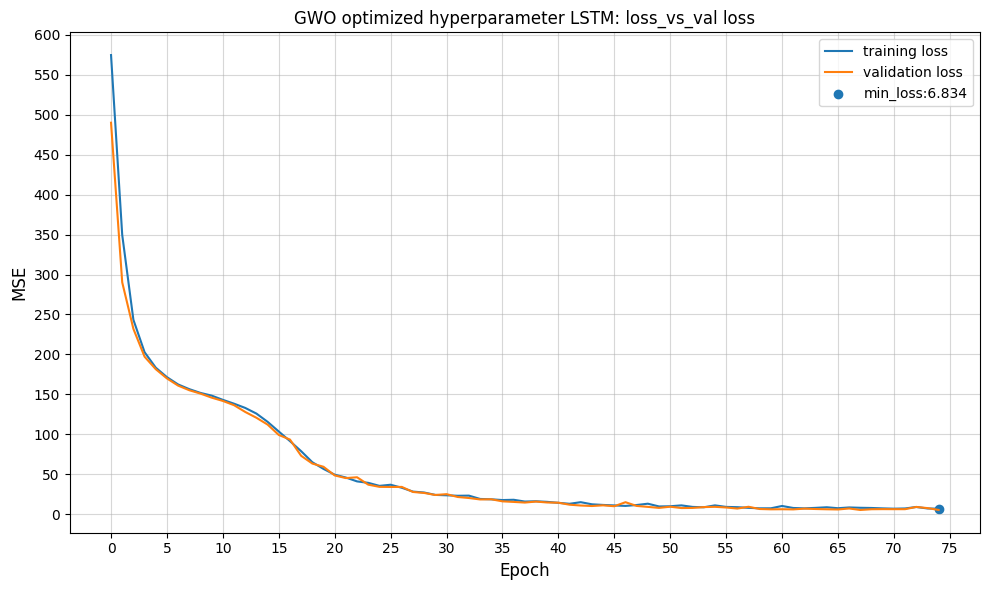

In [24]:
plt.figure(figsize=(10, 6))

# Plotting loss
plt.plot(gwo_history.history['loss'])
plt.plot(gwo_history.history['val_loss'])


# Adding grid
plt.scatter(np.argmin(gwo_history.history['loss']), min(gwo_history.history['loss']))

plt.grid(True, alpha=0.5)
plt.legend(['training loss', 'validation loss', f"min_loss:{ round(min(gwo_history.history['loss']), ndigits=3) }"])

plt.xticks(np.arange(0, 80, 5))
plt.yticks(np.arange(0, 650, 50))

plt.xlabel('Epoch', fontsize=12)
plt.ylabel('MSE', fontsize=12)


#plt.legend(['loss','val_loss'])
plt.title("GWO optimized hyperparameter LSTM: loss_vs_val loss")

plt.tight_layout()
plt.savefig('img/gwo_param_loss_plot2.png')
plt.show()

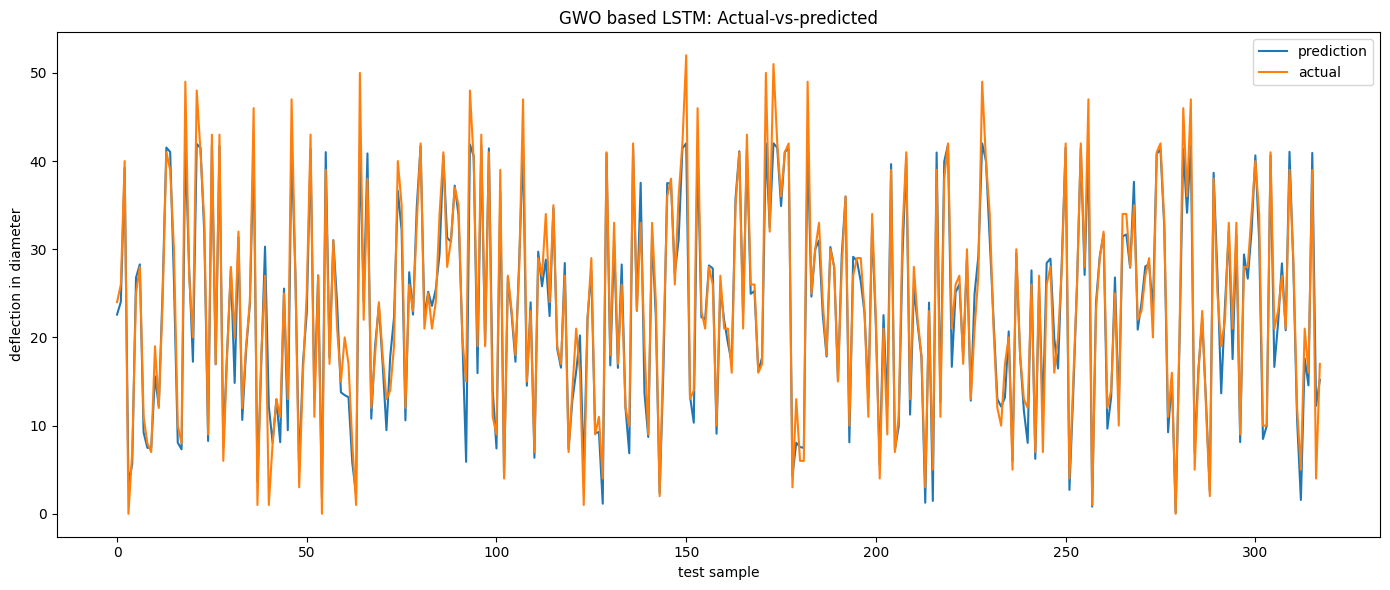

In [25]:
plt.figure(figsize=(14, 6))

# Plotting loss
plt.plot(gwo_y_pred, label='prediction')
plt.plot(test_y, label='actual')

plt.ylabel('deflection in diameter')
plt.xlabel('test sample')

plt.legend()

plt.title("GWO based LSTM: Actual-vs-predicted")

plt.tight_layout()
plt.savefig('img/gwo_based_actual_predicted2.png')
plt.show()

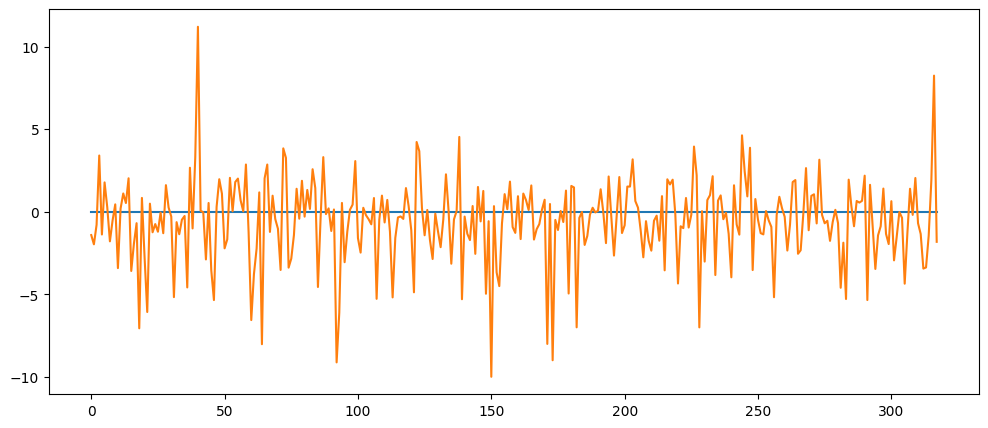

In [26]:
error = gwo_y_pred.reshape(-1)-test_y
np.round(error, 2)

plt.figure(figsize=(12,5))
plt.plot(np.array([0]*len(error)))
plt.plot(error)

In [27]:
print(f"max: {max(error)}; min: {min(error)}")

max: 11.20101547241211; min: -9.981521606445312


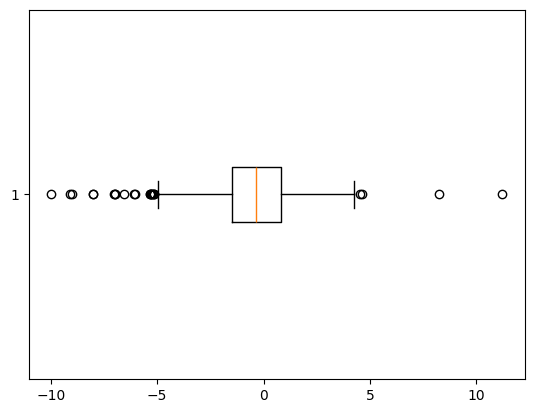

In [38]:
plt.boxplot(error,orientation='horizontal', showbox=True)
plt.savefig('img/boxplot_error.png')


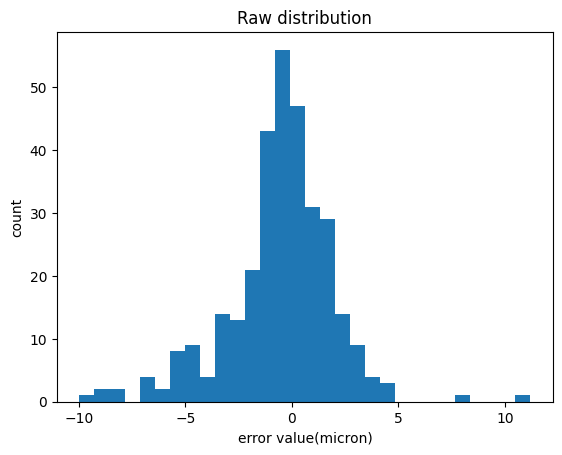

In [30]:
error.std()

np.float64(2.5055966998799413)

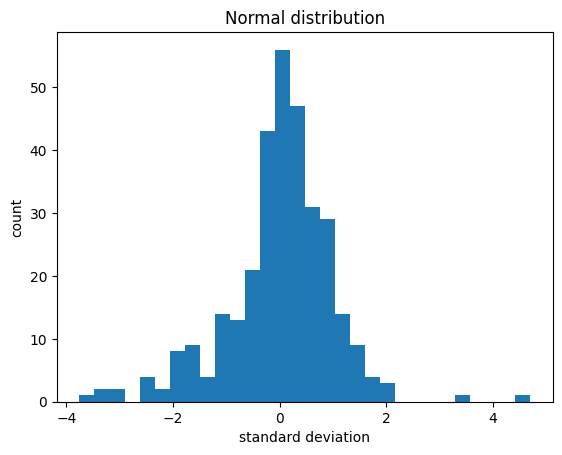

In [ ]:
plt.hist(error, bins=30)
plt.xlabel('error value(micron)')
plt.ylabel('count')
plt.title("Raw distribution")

plt.savefig('img/distribution_of_error.png')

plt.hist((error- error.mean())/error.std(), bins=30)
plt.xlabel('standard deviation')
plt.ylabel('count')
plt.title("Normal distribution")

plt.savefig('img/normal_distribution_of_error.png')

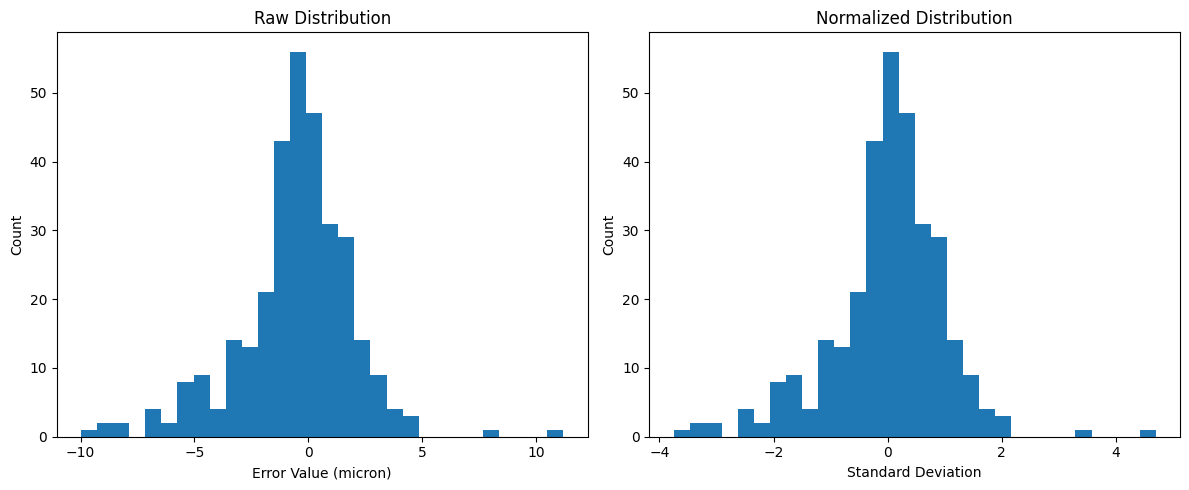

In [51]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot 1: Raw distribution
axes[0].hist(error, bins=30)
axes[0].set_xlabel('Error Value (micron)')
axes[0].set_ylabel('Count')
axes[0].set_title('Raw Distribution')

# Plot 2: Normalized distribution
axes[1].hist((error - error.mean()) / error.std(), bins=30)
axes[1].set_xlabel('Standard Deviation')
axes[1].set_ylabel('Count')
axes[1].set_title('Normalized Distribution')

# Adjust layout for better spacing
fig.tight_layout()

# Save plots
fig.savefig('img/normal_distribution_&_raw_distribution.png')

# Show the plots
plt.show()